In [1]:
%matplotlib inline
import os
import glob
import pandas as pd
import fiona
import rasterio
import rasterio.mask
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

The first input is a list of GeoTIFF files in our directory, sorted alphabetically (ie, by date in ascending order).

In [2]:
snowcover_dir = "/Volumes/CWMobileSSD/Geodata_fires/2020_COVID_AFS/natice_noaa/"
geotiff_subdir = 'GeoTIFF_Products/'
geotiff_dir = os.path.join(snowcover_dir, geotiff_subdir)
tiffiles = sorted(glob.glob(os.path.join(geotiff_dir, "*2020*.tif")))

The second input is a dictionary of (multi)polygons for each Predictive Service Area (PSA). They are, like the GeoTIFFs, in Alaska Albers Equal Area projection. 

In [3]:
psa_file = "/Volumes/CWMobileSSD/Geodata_fires/AICC/AK_PSA_boundaries/predictive_service_areas.shp"
psa_shapes = {}
with fiona.open(psa_file, "r") as shapefile:
    for feature in shapefile:
        psa_shapes[feature['properties']['PSA_NAME']] = feature["geometry"]

In [4]:
psa_shapes.keys()

dict_keys(['Kuskokwim Valley', 'Northern Panhandle', 'Central Panhandle', 'Southern Panhandle', 'Matanuska Valley and Anchorage', 'Kenai Peninsula', 'Tanana Valley-West', 'Susitna Valley', 'Tanana Zone-South', 'Koyukuk and Upper Kobuk', 'Lower Yukon', 'Middle Yukon', 'Upper Yukon Valley', 'Copper River Basin', 'Kodiak Island', 'North Slope', 'Tanana Zone-North', 'Seward Peninsula', 'Bristol Bay and AK Peninsula', 'Yukon-Kuskokwim Delta', 'Tanana Valley-East'])

### Try it out for one sample GeoTiff, and two selected PSA.

Let's pick a GeoTIFF. We can extract the date from the filename, which is unelegant, but effective.

In [5]:
sampletiff = tiffiles[10]
sampletiff[90:98]

'20200311'

We open it using `rasterio`. It expects a list of shapes, but we only provide a list of one. `out_image` will be an array containing a single image. 

In [6]:
with rasterio.open(sampletiff) as src:
    out_image, out_transform = rasterio.mask.mask(src, [psa_shapes['Tanana Valley-West']], crop=True)
    out_meta = src.meta

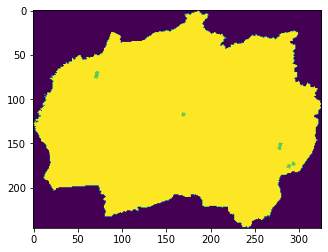

In [7]:
plt.imshow(out_image[0])   

We need to count the unique values in the masked raster. The values are 0 - no data (outside mask), 1 - water, 2 - snow-free ground, 3 - ice, 4 - snow. Note that if there are no pixels for a given value, the value will not appear in the output. We therefore need to populate a short array, including the values with zero counts.

In [8]:
unique_elements, counts_elements = np.unique(out_image[0], return_counts=True)
unique_elements, counts_elements

(array([0, 3, 4], dtype=uint8), array([26879,   118, 53199]))

In [9]:
counts = np.zeros(5)
counts[unique_elements] = counts_elements
counts

array([26879.,     0.,     0.,   118., 53199.])

The Tanana Valley-West zone is still entirely frozen on that date. The counts for snow-free ground and water are zero.

In [10]:
sum(counts[3:]) / sum(counts[1:])

1.0

Let's do the exact same thing with the Kenai Peninsula.

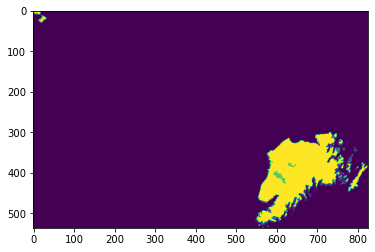

In [11]:
with rasterio.open(sampletiff) as src:
    out_image, out_transform = rasterio.mask.mask(src, [psa_shapes['Kenai Peninsula']], crop=True)
    out_meta = src.meta
plt.imshow(out_image[0])  

In [12]:
unique_elements, counts_elements = np.unique(out_image[0], return_counts=True)
counts = np.zeros(5)
counts[unique_elements] = counts_elements
sum(counts[3:]) / sum(counts[1:])

0.9117329299913569

### A quick-and-dirty time series for sample PSAs

As a sanity check / quality control, let's produce sample time series plots for these two PSAs. They look quite reasonable. 

In [6]:
labels = []
tanana_west = []
kenai = []
for tiffile in tiffiles:
    labels.append(tiffile[90:98])
    with rasterio.open(tiffile) as src:
        kenai_img, _ = rasterio.mask.mask(src, [psa_shapes['Kenai Peninsula']], crop=True)
        tanana_west_img, _ = rasterio.mask.mask(src, [psa_shapes['Tanana Valley-West']], crop=True)
    unique_kenai, counts_kenai = np.unique(kenai_img[0], return_counts=True)
    counts = np.zeros(5)
    counts[unique_kenai] = counts_kenai
    kenai.append(sum(counts[3:]) / sum(counts[1:]))
    unique_tanana_west, counts_tanana_west = np.unique(tanana_west_img[0], return_counts=True)
    counts = np.zeros(5)
    counts[unique_tanana_west] = counts_tanana_west
    tanana_west.append(sum(counts[3:]) / sum(counts[1:]))
    

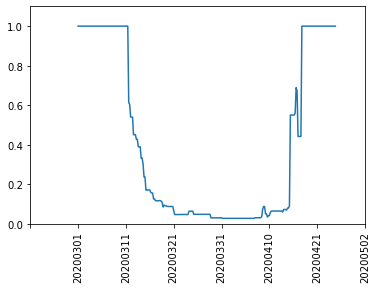

In [7]:
plt.plot(tanana_west)
locs, _ = plt.xticks()
_ = plt.xticks(locs, [''] + labels[::10], rotation=90)
_ = plt.ylim((0,1.1))

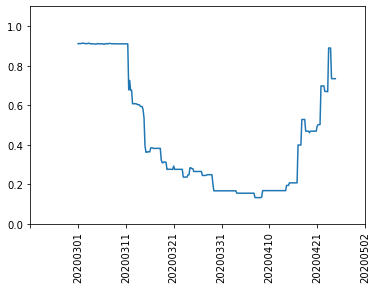

In [8]:
plt.plot(kenai)
locs, _ = plt.xticks()
_ = plt.xticks(locs, [''] + labels[::10], rotation=90)
_ = plt.ylim((0,1.1))

### Let's generate, save and visualize a complete dataset

We will first put the data in a large dictionary, then generate a Pandas Dataframe from the dictionary. 

In [9]:
datadict = {}

for tiffile in tiffiles:
    try: 
        datadict['date'].append(tiffile[90:98])
    except KeyError:
        datadict['date'] = [tiffile[90:98]]
    with rasterio.open(tiffile) as src:
        for psa in psa_shapes:
            psa_img, _ = rasterio.mask.mask(src, [psa_shapes[psa]], crop=True)
            unique_psa, counts_psa = np.unique(psa_img[0], return_counts=True)
            counts = np.zeros(5)
            counts[unique_psa] = counts_psa
            try: 
                datadict[psa].append(sum(counts[3:]) / sum(counts[1:]))
            except KeyError:
                datadict[psa] = [sum(counts[3:]) / sum(counts[1:])]   

In [10]:
snowdata_df = pd.DataFrame.from_dict(datadict)
snowdata_df

,date,Kuskokwim Valley,Northern Panhandle,Central Panhandle,Southern Panhandle,Matanuska Valley and Anchorage,Kenai Peninsula,Tanana Valley-West,Susitna Valley,Tanana Zone-South,...,Middle Yukon,Upper Yukon Valley,Copper River Basin,Kodiak Island,North Slope,Tanana Zone-North,Seward Peninsula,Bristol Bay and AK Peninsula,Yukon-Kuskokwim Delta,Tanana Valley-East
0,20200301,1.000000,0.837905,0.678072,0.670925,0.999841,0.911517,1.0,1.00000,1.0,...,1.0,1.000000,0.976950,0.785115,1.000000,1.0,1.000000,0.991471,0.999890,1.0
1,20200302,1.000000,0.837905,0.678072,0.670925,0.999841,0.911517,1.0,1.00000,1.0,...,1.0,1.000000,0.976950,0.785115,1.000000,1.0,1.000000,0.991820,0.999890,1.0
2,20200303,1.000000,0.837905,0.678072,0.670925,0.999841,0.911517,1.0,1.00000,1.0,...,1.0,1.000000,0.976950,0.785115,1.000000,1.0,1.000000,0.990970,0.999890,1.0
3,20200304,1.000000,0.837905,0.678072,0.670925,0.999841,0.911517,1.0,1.00000,1.0,...,1.0,1.000000,0.976950,0.785115,1.000000,1.0,1.000000,0.990766,0.999890,1.0
4,20200305,1.000000,0.840219,0.678072,0.670925,1.000000,0.913462,1.0,1.00000,1.0,...,1.0,1.000000,0.976950,0.805859,1.000000,1.0,1.000000,0.993131,1.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,20201130,0.999989,0.839573,0.673167,0.591913,0.975171,0.734190,1.0,0.99496,1.0,...,1.0,0.999923,0.976876,0.805859,0.999981,1.0,0.995399,0.917923,0.994001,1.0
266,20201201,0.999989,0.839573,0.673167,0.591913,0.975171,0.734190,1.0,0.99496,1.0,...,1.0,0.999923,0.976876,0.805859,0.999981,1.0,0.995594,0.920546,0.994001,1.0
267,20201202,0.999989,0.839573,0.673167,0.591913,0.975171,0.734190,1.0,0.99496,1.0,...,1.0,0.999923,0.976876,0.805859,0.999981,1.0,0.995594,0.920546,0.994001,1.0
268,20201203,0.999989,0.839573,0.673167,0.591220,0.975171,0.734190,1.0,0.99496,1.0,...,1.0,0.999923,0.976876,0.805859,0.999981,1.0,0.995385,0.921600,0.994573,1.0


In [11]:
snowdata_df.index = pd.to_datetime(snowdata_df["date"], format="%Y%m%d")
snowdata_df

,date,Kuskokwim Valley,Northern Panhandle,Central Panhandle,Southern Panhandle,Matanuska Valley and Anchorage,Kenai Peninsula,Tanana Valley-West,Susitna Valley,Tanana Zone-South,...,Middle Yukon,Upper Yukon Valley,Copper River Basin,Kodiak Island,North Slope,Tanana Zone-North,Seward Peninsula,Bristol Bay and AK Peninsula,Yukon-Kuskokwim Delta,Tanana Valley-East
date,,,,,,,,,,,,,,,,,,,,,
2020-03-01,20200301,1.000000,0.837905,0.678072,0.670925,0.999841,0.911517,1.0,1.00000,1.0,...,1.0,1.000000,0.976950,0.785115,1.000000,1.0,1.000000,0.991471,0.999890,1.0
2020-03-02,20200302,1.000000,0.837905,0.678072,0.670925,0.999841,0.911517,1.0,1.00000,1.0,...,1.0,1.000000,0.976950,0.785115,1.000000,1.0,1.000000,0.991820,0.999890,1.0
2020-03-03,20200303,1.000000,0.837905,0.678072,0.670925,0.999841,0.911517,1.0,1.00000,1.0,...,1.0,1.000000,0.976950,0.785115,1.000000,1.0,1.000000,0.990970,0.999890,1.0
2020-03-04,20200304,1.000000,0.837905,0.678072,0.670925,0.999841,0.911517,1.0,1.00000,1.0,...,1.0,1.000000,0.976950,0.785115,1.000000,1.0,1.000000,0.990766,0.999890,1.0
2020-03-05,20200305,1.000000,0.840219,0.678072,0.670925,1.000000,0.913462,1.0,1.00000,1.0,...,1.0,1.000000,0.976950,0.805859,1.000000,1.0,1.000000,0.993131,1.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-30,20201130,0.999989,0.839573,0.673167,0.591913,0.975171,0.734190,1.0,0.99496,1.0,...,1.0,0.999923,0.976876,0.805859,0.999981,1.0,0.995399,0.917923,0.994001,1.0
2020-12-01,20201201,0.999989,0.839573,0.673167,0.591913,0.975171,0.734190,1.0,0.99496,1.0,...,1.0,0.999923,0.976876,0.805859,0.999981,1.0,0.995594,0.920546,0.994001,1.0
2020-12-02,20201202,0.999989,0.839573,0.673167,0.591913,0.975171,0.734190,1.0,0.99496,1.0,...,1.0,0.999923,0.976876,0.805859,0.999981,1.0,0.995594,0.920546,0.994001,1.0


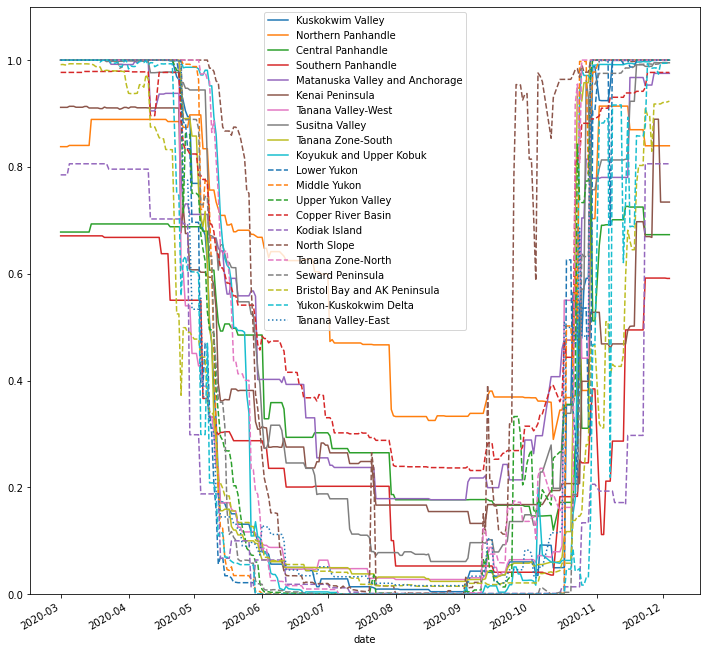

In [12]:
_ = snowdata_df.plot(figsize=(12,12), ylim=(0,1.1), style=['-']*10+['--']*10+[':'])

In [19]:
PSA0 = [
    'North Slope',
    'Koyukuk and Upper Kobuk',
    'Seward Peninsula',
    'Tanana Zone-North',
]
PSA1 = [
    'Lower Yukon',
    'Middle Yukon',
    'Kuskokwim Valley',
    'Yukon-Kuskokwim Delta',
]
PSA2 = [
    'Tanana Valley-West',
    'Tanana Zone-South',
    'Tanana Valley-East',
    'Upper Yukon Valley',
]
PSA3 = [
    'Susitna Valley',
    'Matanuska Valley and Anchorage',
    'Copper River Basin',
]
PSA4 = [
    'Bristol Bay and AK Peninsula',
    'Kenai Peninsula',
    'Kodiak Island',
]
PSA5 = [
    'Northern Panhandle', 
    'Central Panhandle', 
    'Southern Panhandle'
]
PSA_justTVW = [
    'Tanana Valley-West']

In [23]:
snowdata_df[PSA_justTVW]

,Tanana Valley-West
date,
2020-03-01,1.0
2020-03-02,1.0
2020-03-03,1.0
2020-03-04,1.0
2020-03-05,1.0
...,...
2020-11-30,1.0
2020-12-01,1.0
2020-12-02,1.0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x121ed1d30>,
      dtype=object)

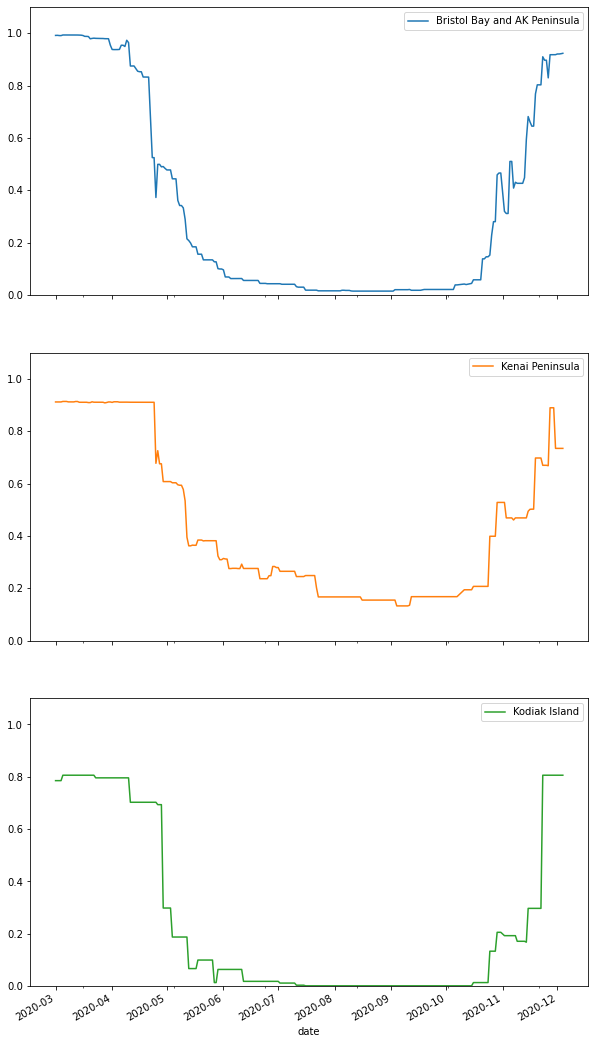

In [14]:
snowdata_df[PSA4].plot(subplots=True, figsize=(10,20), ylim=(0,1.1))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1228f7da0>,
      dtype=object)

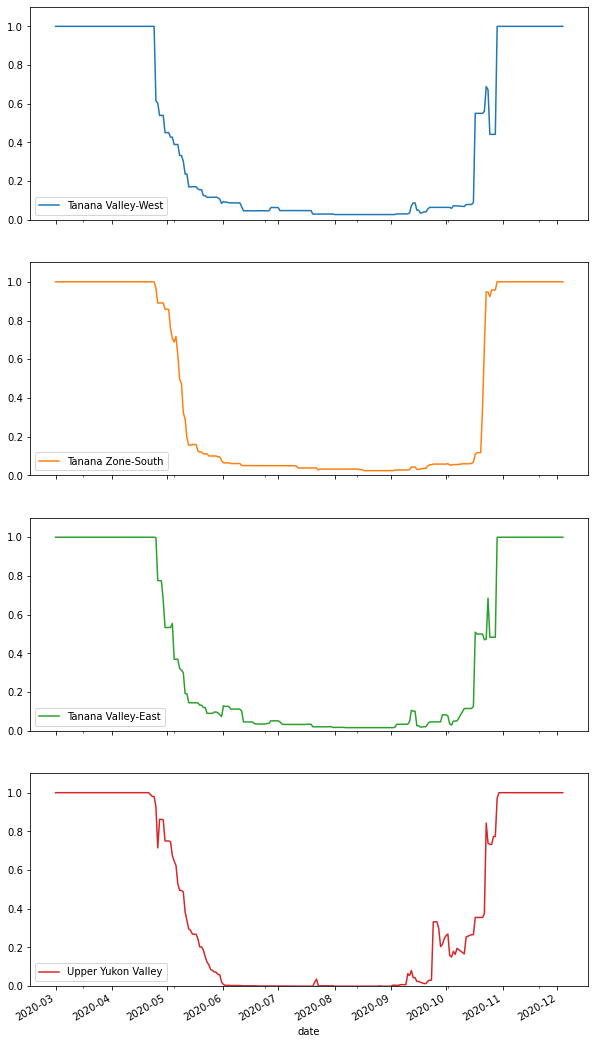

In [15]:
snowdata_df[PSA2].plot(subplots=True, figsize=(10,20), ylim=(0,1.1))

In [16]:
sns.set_style('darkgrid')

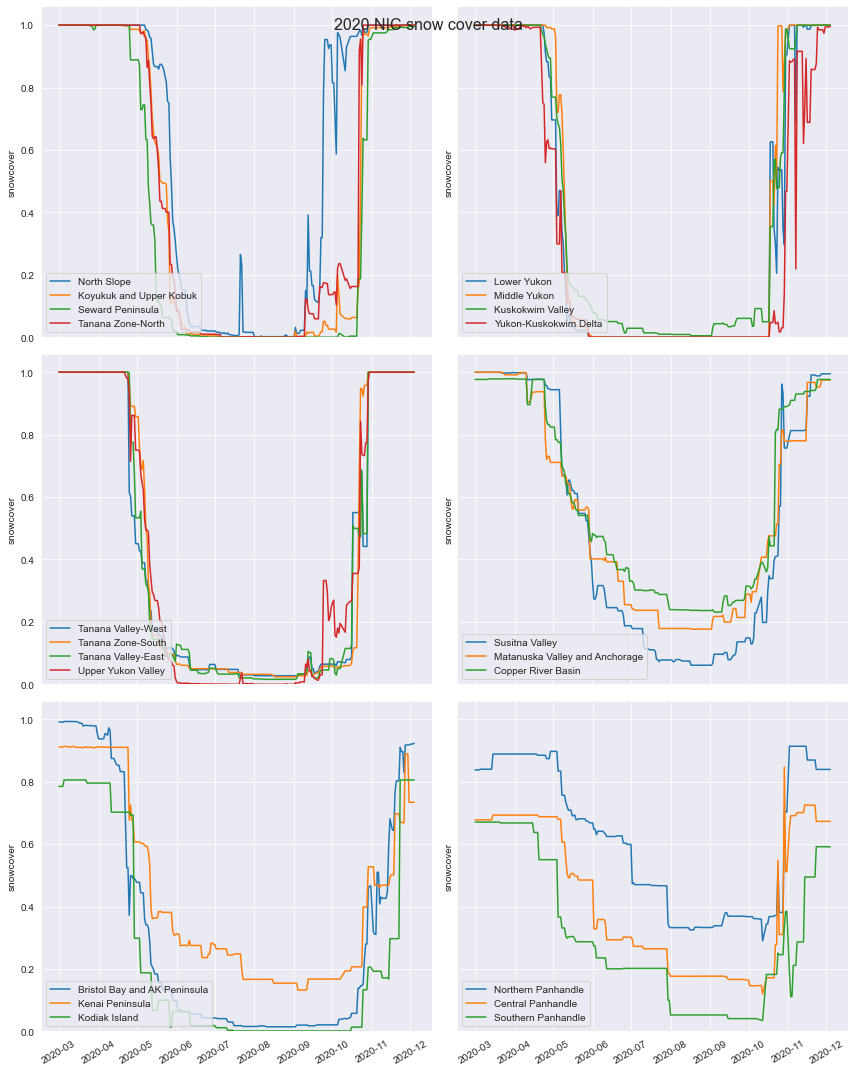

In [17]:
fig, axes = plt.subplots(3, 2, figsize=(12, 15), sharex=True, sharey=True)
for ax, grp in zip(axes.flatten(), [PSA0, PSA1, PSA2, PSA3, PSA4, PSA5,]):
    g = sns.lineplot(data = snowdata_df[grp], dashes=False, ax=ax)
    g.set_xlabel("")
    g.set_ylabel("snowcover")
    g.set_ylim((0,1.06))
    _ = plt.setp(g.get_xticklabels(), rotation=30)
    _ = ax.legend(loc='lower left')
_ = fig.suptitle("2020 NIC snow cover data", fontsize=16)
plt.tight_layout()

### Saving data to file

In [18]:
compression_opts = dict(method='zip', archive_name='snowcoverAK_2020.csv')
snowdata_df.to_csv('snowcoverAK_2020.zip', compression=compression_opts)

### Quick comparison with MODIS

In [24]:
snowdata_MODIS = pd.read_csv("TVW_2020_MODIS")
snowdata_MODIS = snowdata_MODIS.drop(['Unnamed: 0'], axis=1)

In [36]:
snowdata_MODIS.columns = ['date', 'TVW MODIS']

In [53]:
snowdata_MODIS["datestamp"] = pd.to_datetime(snowdata_MODIS["date"])
snowdata_MODIS = snowdata_MODIS.set_index('datestamp')
snowdata_MODIS = snowdata_MODIS.drop(['date'], axis=1)

In [39]:
snowdata_TVW_NIC = snowdata_df[PSA_justTVW].copy()

In [46]:
snowdata_TVW_NIC.columns = ["TVW NIC"]
snowdata_TVW_NIC["TVW NIC"] = snowdata_TVW_NIC["TVW NIC"] * 100

In [56]:
snowdata_merged = pd.merge(snowdata_TVW_NIC, snowdata_MODIS, how='inner', left_index=True, right_index=True)


In [57]:
snowdata_merged

,TVW NIC,TVW MODIS
2020-03-01,100.0,52.359572
2020-03-02,100.0,57.668677
2020-03-03,100.0,55.326377
2020-03-04,100.0,56.333950
2020-03-05,100.0,63.795156
...,...,...
2020-11-25,100.0,NaN
2020-11-26,100.0,63.935281
2020-11-27,100.0,NaN
2020-11-28,100.0,NaN


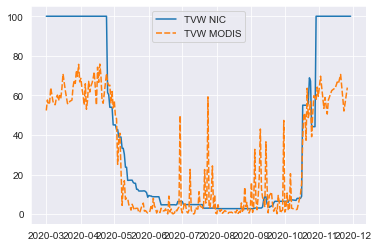

In [58]:
ax = sns.lineplot(data=snowdata_merged)

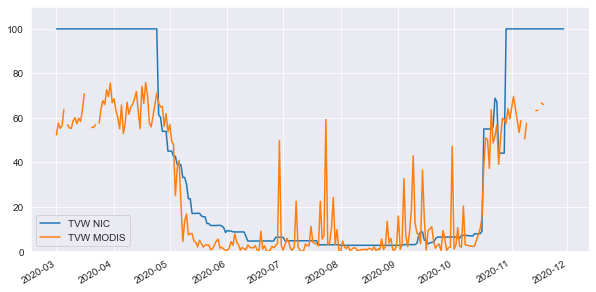

In [61]:
snowdata_merged.plot(figsize=(10,5), ylim=(0,110))